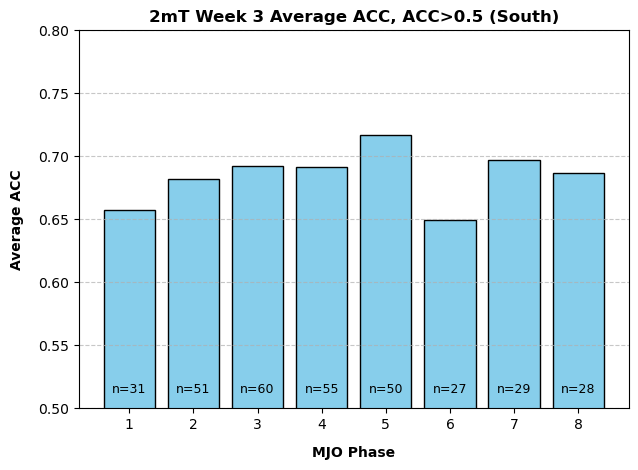

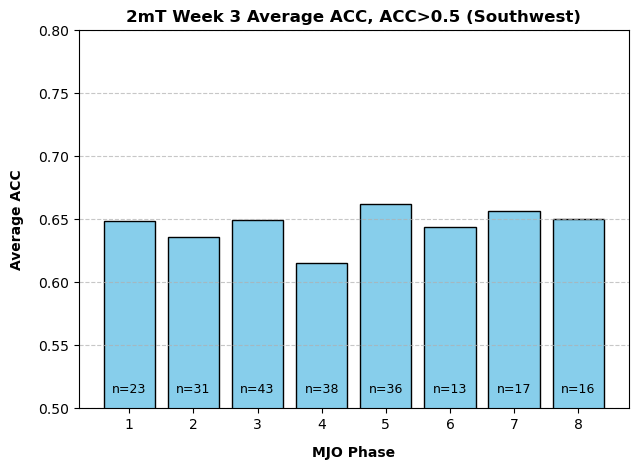

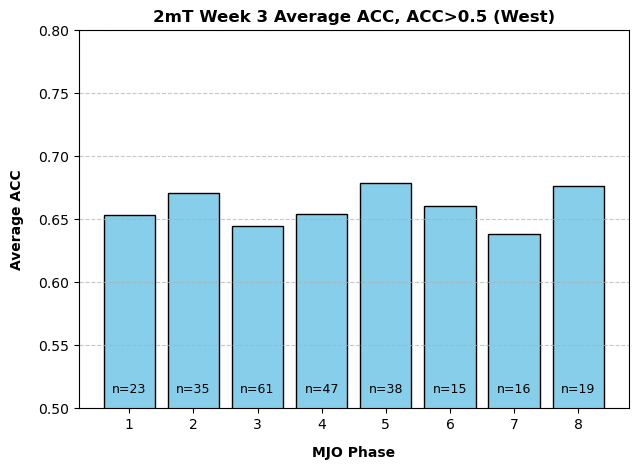

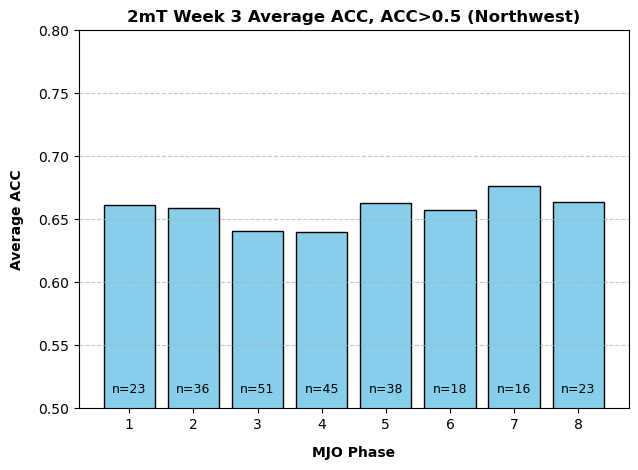

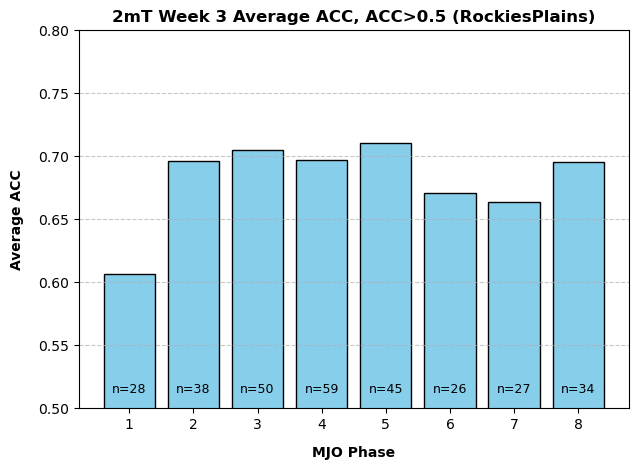

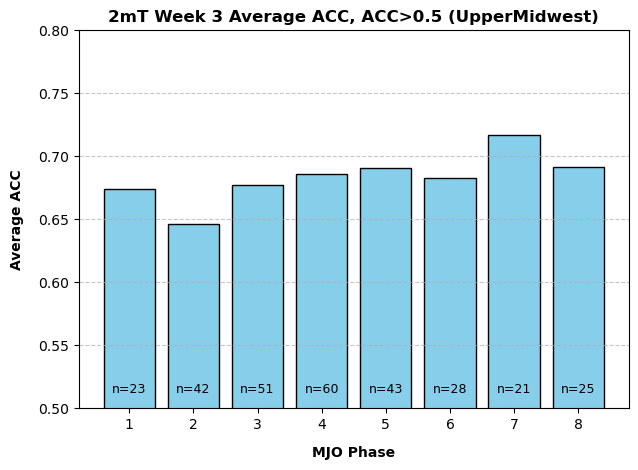

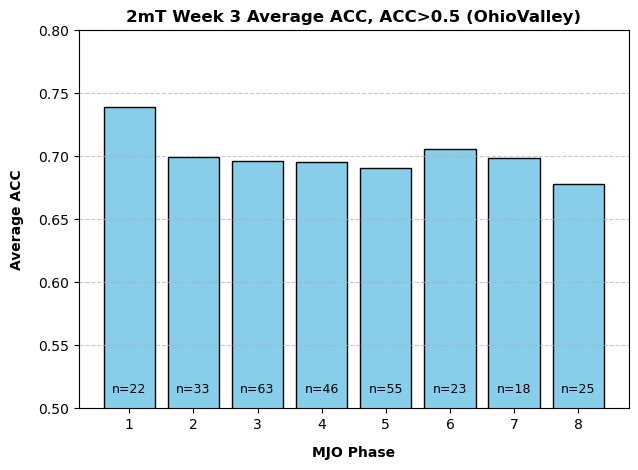

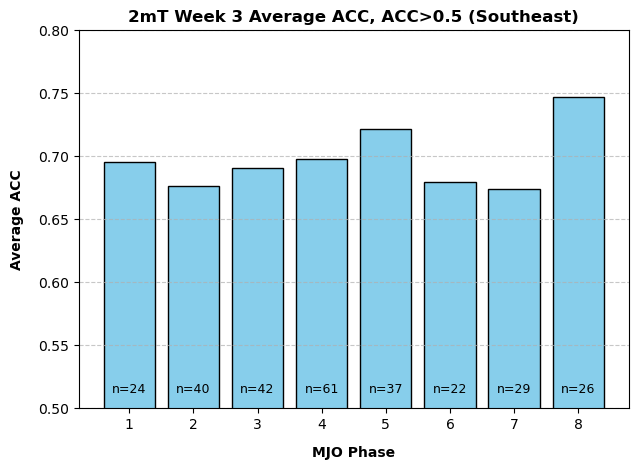

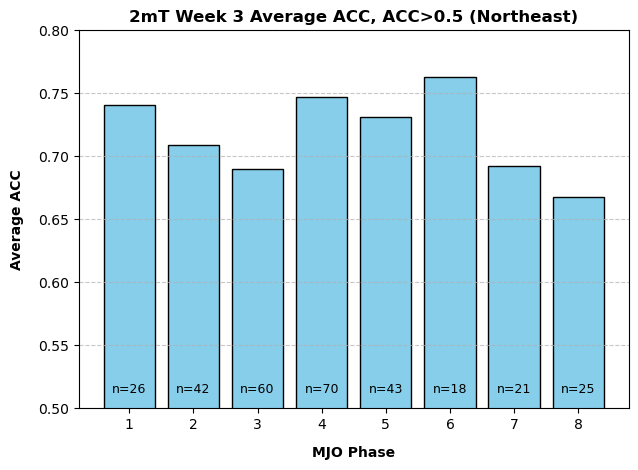

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '/glade/work/sglanvil/CCR/S2S_windowsOfOpportunity/indices/rmm_index_cesm2cam6v2_ALL.nc'
ds = xr.open_dataset(file, decode_times=False)
raw_time = ds['time'].values
initMJO = pd.to_datetime(raw_time, unit='D', origin=pd.Timestamp('1970-01-01 12:00:00'))
ds = ds.assign_coords(time=initMJO)
rmm1_sel = ds['rmm1'].mean(dim='member').isel(lead=0) 
rmm2_sel = ds['rmm2'].mean(dim='member').isel(lead=0) 
MJOamp = np.sqrt(rmm1_sel**2 + rmm2_sel**2)
MJOprop = np.arctan2(rmm1_sel, rmm2_sel)

# Define the phase edges in radians
edges = np.array([-np.pi,
    -3*np.pi/4,
    -np.pi/2,
    -np.pi/4,
    0,
    np.pi/4,
    np.pi/2,
    3*np.pi/4,
    np.pi])
# Define corresponding phase numbers (1 to 8)
phases = np.arange(1, 9)
# Use np.digitize to assign phases
MJOphase = np.digitize(MJOprop, edges[1:], right=True) + 1


fileSIM = '/glade/campaign/cesm/development/cross-wg/S2S/sglanvil/data/tas_2m_anom_cesm2cam6v2.scenario1_s2s_data.nc'
ds = xr.open_dataset(fileSIM)
initSIM = pd.to_datetime(ds['date'], format='%Y%m%d')

common_dates = initMJO.intersection(initSIM)
idx_in_MJO = initMJO.get_indexer(common_dates)
idx_in_SIM = initSIM.get_indexer(common_dates)
MJOampFinal = MJOamp[idx_in_MJO]
MJOpropFinal = MJOprop[idx_in_MJO]
MJOphaseFinal = MJOphase[idx_in_MJO]

region_groups = {'South': ['Kansas', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana', 'Mississippi'],
    'Southwest': ['Colorado', 'Arizona', 'Utah', 'New Mexico'],
    'West': ['California', 'Nevada'],
    'Northwest': ['Washington', 'Oregon', 'Idaho'],
    'RockiesPlains': ['Montana', 'Wyoming', 'North Dakota', 'South Dakota', 'Nebraska'],
    'UpperMidwest': ['Minnesota', 'Iowa', 'Wisconsin', 'Michigan'],
    'OhioValley': ['Missouri', 'Illinois', 'Indiana', 'Ohio', 'West Virginia', 'Kentucky', 'Tennessee'],
    'Southeast': ['Alabama', 'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Virginia'],
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'Maryland', 
                  'Delaware', 'New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'District of Columbia']}
ds = xr.open_zarr("2mT_ACC_week3_byRegion_data.zarr")
for region_name in region_groups:
    R = ds[region_name][idx_in_SIM]
    R = R.values
    
    # plt.scatter(MJOphaseFinal, R)
    # plt.xlabel('MJO Phase', fontweight='bold', labelpad=10)
    # plt.ylabel('Average ACC', fontweight='bold', labelpad=10)
    # plt.title('2mT Week 3 Average ACC ('+region_name+')', fontweight='bold')
    # plt.xticks(np.arange(1, 9))
    # plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    # plt.ylim(0.5, 1)
    # plt.savefig("2mT_ACC_week3_MJOphase_scatter_"+ region_name +".png", dpi=300)
    # plt.show()
    
    mean_R_per_phase = np.zeros(8)
    counts = np.zeros(8, dtype=int)
    for phase in range(1, 9):
        # mask = MJOphaseFinal == phase
        mask = (MJOphaseFinal == phase) & (R > 0.5)
        mean_R_per_phase[phase - 1] = R[mask].mean()
        counts[phase - 1] = np.sum(mask)
    bars = plt.bar(np.arange(1, 9), mean_R_per_phase, color='skyblue', edgecolor='k')
    for i, count in enumerate(counts):
        plt.text(i+1, 0.51, f'n={count}', ha='center', va='bottom', fontsize=9, color='black')
    plt.xlabel('MJO Phase', fontweight='bold', labelpad=10)
    plt.ylabel('Average ACC', fontweight='bold', labelpad=10)
    plt.title('2mT Week 3 Average ACC, ACC>0.5 ('+region_name+')', fontweight='bold')
    plt.xticks(np.arange(1, 9))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.ylim(-0.04, 0.27)
    plt.ylim(0.5, 0.8)
    plt.axhline(0, color='black', linewidth=1.5)
    plt.savefig("2mT_ACC_week3_MJOphase_bar_ACCgt05_"+ region_name +".png", dpi=300)
    plt.show()

